In [3]:
from pathlib import Path

# auto-detect project root by finding "data" folder
root = Path.cwd()
while root != root.parent and not (root / "data").exists():
    root = root.parent

print("Detected root:", root)
print("Merged exists:", (root / "data/merged").exists())
print("Has file:", (root / "data/merged/train_audio_lyrics_final_kept.parquet").exists())

Detected root: c:\Users\HP\Documents\music_vae_project
Merged exists: True
Has file: True


In [4]:
import pandas as pd
import numpy as np
from scipy import sparse

df = pd.read_parquet(root / "data/merged/train_audio_lyrics_final_kept.parquet")
X_audio = np.load(root / "data/merged/X_audio_mfcc.npy")
X_lyrics = sparse.load_npz(root / "data/merged/X_lyrics_tfidf.npz").toarray()

print("df rows:", len(df))
print("X_audio:", X_audio.shape)
print("X_lyrics:", X_lyrics.shape)


df rows: 1432
X_audio: (1432, 12000)
X_lyrics: (1432, 5000)


In [5]:
from pathlib import Path
print("cwd:", Path.cwd())
print("data exists:", (Path.cwd() / "data").exists())
print("file exists:", (Path.cwd() / "data/merged/train_audio_lyrics_final_kept.parquet").exists())
print("alt file exists:", (Path.cwd() / "data/merged/train_audio_lyrics_final.parquet").exists())

cwd: c:\Users\HP\Documents\music_vae_project\notebooks\notebooks
data exists: False
file exists: False
alt file exists: False


In [6]:
from pathlib import Path

# auto-detect project root by finding "data" folder
root = Path.cwd()
while root != root.parent and not (root / "data").exists():
    root = root.parent

print("Detected root:", root)
print("Merged exists:", (root / "data/merged").exists())
print("Has file:", (root / "data/merged/train_audio_lyrics_final_kept.parquet").exists())


Detected root: c:\Users\HP\Documents\music_vae_project
Merged exists: True
Has file: True


In [7]:
import pandas as pd
import numpy as np
from scipy import sparse

df = pd.read_parquet(root / "data/merged/train_audio_lyrics_final_kept.parquet")
X_audio = np.load(root / "data/merged/X_audio_mfcc.npy")
X_lyrics = sparse.load_npz(root / "data/merged/X_lyrics_tfidf.npz").toarray()

print("df rows:", len(df))
print("X_audio:", X_audio.shape)
print("X_lyrics:", X_lyrics.shape)


df rows: 1432
X_audio: (1432, 12000)
X_lyrics: (1432, 5000)


In [15]:
print("FINAL DATASET USED (audio+lyrics):", len(df))

FINAL DATASET USED (audio+lyrics): 1432


In [8]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# balance (works well)
X = np.hstack([X_audio * 0.7, X_lyrics * 1.3])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("X_scaled:", X_scaled.shape)


X_scaled: (1432, 17000)


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(42)
np.random.seed(42)

X_tensor = torch.tensor(X_scaled.astype(np.float32))

input_dim = X_tensor.shape[1]
latent_dim = 32
beta = 0.01

class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Linear(input_dim, 512), nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, 256), nn.ReLU(),
            nn.Linear(256, 128), nn.ReLU()
        )
        self.mu = nn.Linear(128, latent_dim)
        self.logvar = nn.Linear(128, latent_dim)
        self.dec = nn.Sequential(
            nn.Linear(latent_dim, 128), nn.ReLU(),
            nn.Linear(128, 256), nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 512), nn.ReLU(),
            nn.Linear(512, input_dim)
        )

    def reparam(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.enc(x)
        mu = self.mu(h)
        logvar = self.logvar(h)
        z = self.reparam(mu, logvar)
        x_hat = self.dec(z)
        return x_hat, mu, logvar

def loss_fn(x_hat, x, mu, logvar, beta=0.01):
    recon = ((x_hat - x) ** 2).mean()
    kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon + beta * kl, recon, kl

model = VAE(input_dim, latent_dim)
opt = optim.Adam(model.parameters(), lr=1e-3)

epochs = 30
batch_size = 64

for ep in range(1, epochs+1):
    perm = torch.randperm(X_tensor.size(0))
    total = 0
    for i in range(0, X_tensor.size(0), batch_size):
        idx = perm[i:i+batch_size]
        xb = X_tensor[idx]
        x_hat, mu, logvar = model(xb)
        loss, recon, kl = loss_fn(x_hat, xb, mu, logvar, beta=beta)
        opt.zero_grad()
        loss.backward()
        opt.step()
        total += loss.item() * xb.size(0)
    print(f"epoch {ep}/{epochs} loss={total/X_tensor.size(0):.4f}")


epoch 1/30 loss=1.0010
epoch 2/30 loss=1.0004
epoch 3/30 loss=0.9931
epoch 4/30 loss=0.9783
epoch 5/30 loss=0.9753
epoch 6/30 loss=0.9731
epoch 7/30 loss=0.9681
epoch 8/30 loss=0.9651
epoch 9/30 loss=0.9623
epoch 10/30 loss=0.9599
epoch 11/30 loss=0.9589
epoch 12/30 loss=0.9575
epoch 13/30 loss=0.9565
epoch 14/30 loss=0.9556
epoch 15/30 loss=0.9543
epoch 16/30 loss=0.9533
epoch 17/30 loss=0.9523
epoch 18/30 loss=0.9513
epoch 19/30 loss=0.9497
epoch 20/30 loss=0.9478
epoch 21/30 loss=0.9463
epoch 22/30 loss=0.9447
epoch 23/30 loss=0.9433
epoch 24/30 loss=0.9421
epoch 25/30 loss=0.9416
epoch 26/30 loss=0.9393
epoch 27/30 loss=0.9376
epoch 28/30 loss=0.9357
epoch 29/30 loss=0.9343
epoch 30/30 loss=0.9326


In [10]:
with torch.no_grad():
    h = model.enc(X_tensor)
    z = model.mu(h).numpy()

print("z shape:", z.shape)

z shape: (1432, 32)


In [16]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

# PCA baseline latent
pca = PCA(n_components=32, random_state=42)
z_pca = pca.fit_transform(X_scaled)

labels_pca = KMeans(n_clusters=best_k, random_state=42, n_init="auto").fit_predict(z_pca)

sil_pca = silhouette_score(z_pca, labels_pca)
db_pca = davies_bouldin_score(z_pca, labels_pca)

print("PCA+KMeans silhouette:", sil_pca)
print("PCA+KMeans DB:", db_pca)


PCA+KMeans silhouette: 0.04710070384463372
PCA+KMeans DB: 3.4245684243506873


Conv1D VAE on MFCC (audio-only)

In [19]:
import torch
import numpy as np

torch.manual_seed(42)
np.random.seed(42)

# X_audio: (1432, 12000)
Xa = X_audio.astype(np.float32)
Xa_t = torch.tensor(Xa).unsqueeze(1)  # (N, 1, 12000)

print("Xa_t shape:", Xa_t.shape)


Xa_t shape: torch.Size([1432, 1, 12000])


In [24]:
import torch.nn as nn
import torch.optim as optim
import torch

latent_dim_conv = 16
beta_conv = 0.001

class ConvVAE(nn.Module):
    def __init__(self, latent_dim=16):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=9, stride=2, padding=4), nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=9, stride=2, padding=4), nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=9, stride=2, padding=4), nn.ReLU(),
        )
        with torch.no_grad():
            dummy = torch.zeros(1, 1, 12000)
            h = self.enc(dummy)
            self.flat_dim = h.numel()

        self.fc_mu = nn.Linear(self.flat_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.flat_dim, latent_dim)

        self.fc_dec = nn.Linear(latent_dim, self.flat_dim)
        self.dec = nn.Sequential(
            nn.ConvTranspose1d(64, 32, kernel_size=9, stride=2, padding=4, output_padding=1), nn.ReLU(),
            nn.ConvTranspose1d(32, 16, kernel_size=9, stride=2, padding=4, output_padding=1), nn.ReLU(),
            nn.ConvTranspose1d(16, 1, kernel_size=9, stride=2, padding=4, output_padding=1),
        )

    def reparam(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.enc(x).view(x.size(0), -1)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        z = self.reparam(mu, logvar)
        h2 = self.fc_dec(z).view(x.size(0), 64, -1)
        x_hat = self.dec(h2)
        x_hat = x_hat[:, :, :12000]  # crop exact length
        return x_hat, mu, logvar

def conv_loss(x_hat, x, mu, logvar, beta=0.01):
    recon = ((x_hat - x) ** 2).mean()
    kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon + beta * kl, recon, kl

conv_model = ConvVAE(latent_dim=latent_dim_conv)
conv_opt = optim.Adam(conv_model.parameters(), lr=3e-4)

print("ConvVAE flat_dim:", conv_model.flat_dim)


ConvVAE flat_dim: 96000


In [25]:
epochs_conv = 10
batch_size = 64

for ep in range(1, epochs_conv + 1):
    perm = torch.randperm(Xa_t.size(0))
    total = 0
    for i in range(0, Xa_t.size(0), batch_size):
        idx = perm[i:i+batch_size]
        xb = Xa_t[idx]

        x_hat, mu, logvar = conv_model(xb)
        loss, recon, kl = conv_loss(x_hat, xb, mu, logvar, beta=beta_conv)

        conv_opt.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(conv_model.parameters(), 5.0)
        conv_opt.step()

        conv_opt.step()

        total += loss.item() * xb.size(0)

    print(f"[ConvVAE] epoch {ep}/{epochs_conv} loss={total/Xa_t.size(0):.4f}")


[ConvVAE] epoch 1/10 loss=430.0321
[ConvVAE] epoch 2/10 loss=240.6987
[ConvVAE] epoch 3/10 loss=195.9116
[ConvVAE] epoch 4/10 loss=180.5748
[ConvVAE] epoch 5/10 loss=174.8289
[ConvVAE] epoch 6/10 loss=172.2663
[ConvVAE] epoch 7/10 loss=171.1377
[ConvVAE] epoch 8/10 loss=170.1682
[ConvVAE] epoch 9/10 loss=168.4304
[ConvVAE] epoch 10/10 loss=168.1283


In [11]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

scores = {}
best_k, best_score = None, -1

for k in range(4, 16):
    labels = KMeans(n_clusters=k, random_state=42, n_init="auto").fit_predict(z)
    s = silhouette_score(z, labels)
    scores[k] = s
    if s > best_score:
        best_k, best_score = k, s

print("scores:", scores)
print("best_k:", best_k, "best_score:", best_score)


scores: {4: 0.1720750629901886, 5: 0.1848354935646057, 6: 0.17683154344558716, 7: 0.16733336448669434, 8: 0.16011177003383636, 9: 0.16302208602428436, 10: 0.1584191620349884, 11: 0.15939800441265106, 12: 0.14953510463237762, 13: 0.14981690049171448, 14: 0.16019640862941742, 15: 0.15733744204044342}
best_k: 5 best_score: 0.1848354935646057


In [28]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

with torch.no_grad():
    h = conv_model.enc(Xa_t).view(Xa_t.size(0), -1)
    z_audio_conv = conv_model.fc_mu(h).numpy()

print("z_audio_conv shape:", z_audio_conv.shape)

labels_conv = KMeans(n_clusters=best_k, random_state=42, n_init="auto").fit_predict(z_audio_conv)
sil_conv = silhouette_score(z_audio_conv, labels_conv)
db_conv = davies_bouldin_score(z_audio_conv, labels_conv)

print("ConvVAE(audio)+KMeans silhouette:", sil_conv)
print("ConvVAE(audio)+KMeans DB:", db_conv)


z_audio_conv shape: (1432, 16)
ConvVAE(audio)+KMeans silhouette: 0.3497665822505951
ConvVAE(audio)+KMeans DB: 0.9216794504094565


In [29]:
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from sklearn.metrics import davies_bouldin_score
import pandas as pd

results = []
results.append(("ConvVAE(audio)+KMeans", best_k, sil_conv, db_conv))

# KMeans (best_k)
km = KMeans(n_clusters=best_k, random_state=42, n_init="auto")
labels_km = km.fit_predict(z)
results.append(("KMeans", best_k, silhouette_score(z, labels_km), davies_bouldin_score(z, labels_km)))

# Agglomerative (best_k)
ag = AgglomerativeClustering(n_clusters=best_k)
labels_ag = ag.fit_predict(z)
results.append(("Agglomerative", best_k, silhouette_score(z, labels_ag), davies_bouldin_score(z, labels_ag)))
results.append(("PCA+KMeans", best_k, sil_pca, db_pca))
# DBSCAN
for eps in [0.5, 1.0, 1.5]:
    labels_db = DBSCAN(eps=eps, min_samples=5).fit_predict(z)
    if len(set(labels_db)) > 2:
        results.append(("DBSCAN", eps, silhouette_score(z, labels_db), davies_bouldin_score(z, labels_db)))

metrics_df = pd.DataFrame(results, columns=["method","param","silhouette","davies_bouldin"])
metrics_df.to_csv(root / "results/metrics.csv", index=False)

print(metrics_df.sort_values("silhouette", ascending=False))
print("saved: results/metrics.csv")


                  method  param  silhouette  davies_bouldin
0  ConvVAE(audio)+KMeans    5.0    0.349767        0.921679
1                 KMeans    5.0    0.184835        1.431110
2          Agglomerative    5.0    0.130087        1.690495
3             PCA+KMeans    5.0    0.047101        3.424568
4                 DBSCAN    1.0   -0.318296        2.178547
saved: results/metrics.csv


C:\Users\HP\AppData\Roaming\Python\Python313\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


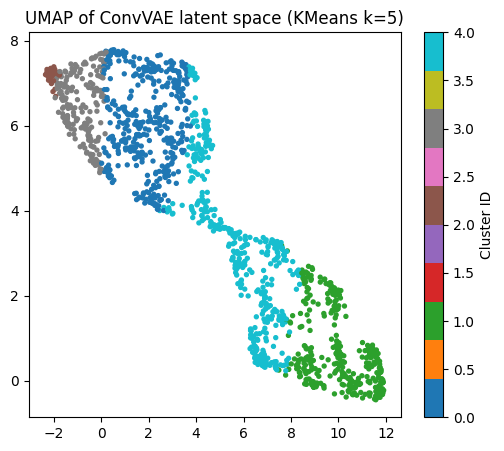

saved: results/plots/latent_umap_convvae.png


In [31]:
import umap
import matplotlib.pyplot as plt

reducer = umap.UMAP(n_neighbors=30, min_dist=0.05, random_state=42)
z2_conv = reducer.fit_transform(z_audio_conv)

plt.figure(figsize=(6,5))
plt.scatter(z2_conv[:,0], z2_conv[:,1], c=labels_conv, s=8, cmap="tab10")
plt.title(f"UMAP of ConvVAE latent space (KMeans k={best_k})")
plt.colorbar(label="Cluster ID")
plt.savefig(root / "results/plots/latent_umap_convvae.png", dpi=200)
plt.show()

print("saved: results/plots/latent_umap_convvae.png")


In [32]:
out_df = df.copy()
out_df["cluster_kmeans"] = labels_km
out_df["cluster_agglom"] = labels_ag

out_df.to_parquet(root / "results/clustered_songs.parquet", index=False)
print("saved: results/clustered_songs.parquet")

saved: results/clustered_songs.parquet
